In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import xarray as xr
import re

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = Path('../Data')
original_seq_path = data_dir / '/Users/thomasbush/Documents/ML/gfp_tryout/data/P42212.fasta.txt'
data_set_path = data_dir / '/Users/thomasbush/Documents/ML/gfp_tryout/data/amino_acid_genotypes_to_brightness.tsv'

In [4]:
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Step 2: Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 3: Import the function from utils.py
from scripts.utils import mutate_sequence, load_seq_, load_dataset

In [5]:
seq, mapping = load_seq_(original_seq_path)

In [6]:
dataset = load_dataset(data_set_path, sep='\t')
seq, mapping = load_seq_(original_seq_path)
dataset['seq_mutated'] = dataset['aaMutations'].apply(
    lambda muts: mutate_sequence(muts, seq=seq, mapping_db_seq=mapping)
)

In [7]:
dataset

,aaMutations,uniqueBarcodes,medianBrightness,std,seq_mutated
0,NaN,3645,3.719212,0.106992,None
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,SA108G,2,3.708478,0.020613,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...,...
54020,SY90N:SN103S:SI169F,1,1.552090,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54021,SY90N:SQ175L:SL205Q:ST228A:SM231V,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54022,SY90R:SI150N:SN196S,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54023,SY90R:SI165T:SL234P,1,1.301517,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [ ]:
# function to generate training data from dataset to respect the propritons of n mutaions in the dataset

,aaMutations,uniqueBarcodes,medianBrightness,std,seq_mutated,num_mut
0,NaN,3645,3.719212,0.106992,None,0
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,5
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4
4,SA108G,2,3.708478,0.020613,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1


### Analysis of MSA changes and delta

In [16]:
def load_a3m_file(file_name: str):
    """
    Loads an A3M (multiple sequence alignment) file and extracts the raw amino acid sequences.

    Args:
        file_name: Path to the A3M file.

    Returns:
        A list of strings where each string represents an individual protein sequence from the input MSA.
    """

    seqs = None
    current_id = None
    seqs = {}
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                current_id = line[1:]
                seqs[current_id] = ""
            elif current_id:
                seqs[current_id] = line

    sequences = [value for value in seqs.values()]

    return sequences

In [17]:
msa_path = '/Users/thomasbush/Documents/ML/gfp_tryout/data/gfp_msa_b5fdc_0.a3m'

sequences = load_a3m_file(msa_path)

### Number of mutations vs changes

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
def get_numb_mut(mut:str)->int:
    if type(mut) == str:
        n = len(mut.split(':'))
    else: 
        return 0
    return n

dataset['num_mut'] = dataset['aaMutations'].apply(lambda mut:get_numb_mut(mut))

In [10]:
# run correlation
dataset['num_mut'].corr(dataset['medianBrightness'],method='spearman' )

np.float64(-0.5514925663083187)

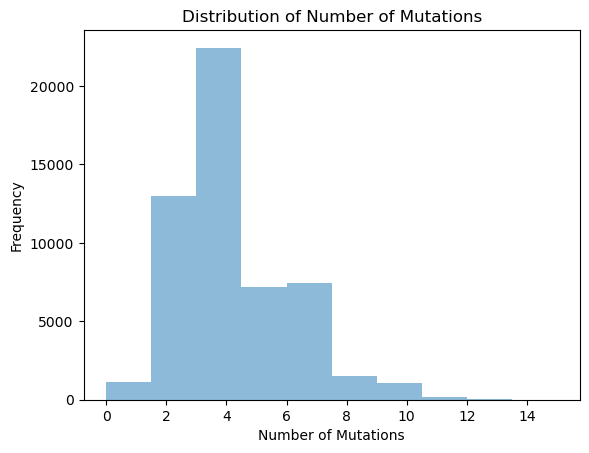

In [11]:
import matplotlib.pyplot as plt


plt.hist(dataset['num_mut'], alpha=0.5)
plt.xlabel('Number of Mutations')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Mutations')
plt.show()

In [13]:
from scripts.balanced_sampling import generate_idx_for_n_mutations


generate_idx_for_n_mutations(dataset, 1000)

Balanced subset created with 1002 samples
Original distribution:
num_mut
0     0.000019
1     0.020620
2     0.240814
3     0.234762
4     0.180639
5     0.133549
6     0.085942
7     0.051513
8     0.028246
9     0.013216
10    0.006516
11    0.002628
12    0.000925
13    0.000463
14    0.000111
15    0.000037
Name: proportion, dtype: float64

Balanced subset distribution:
num_mut
1     0.020958
2     0.240519
3     0.234531
4     0.180639
5     0.133733
6     0.085828
7     0.051896
8     0.027944
9     0.012974
10    0.006986
11    0.002994
12    0.000998
Name: proportion, dtype: float64

Results saved to: balanced_subset.txt


,aaMutations,uniqueBarcodes,medianBrightness,std,seq_mutated,num_mut
30955,SL16M:SK129E,1,3.503791,NaN,MSKGEELFTGVVPILVEMDGDVNGHKFSVSGEGEGDATYGKLTLKF...,2
36810,SN183D:SM231K,1,3.501308,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,2
35443,SN119Y:SD208G,1,1.500171,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,2
33609,SL62P:SP87L,1,1.719540,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,2
40164,SS173G:SH229R,1,3.641148,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,2
...,...,...,...,...,...,...
25229,SK1R:SI45V:SK50R:SQ78R:SA108V:SK207E:SM216V:SV...,1,1.300330,NaN,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,10
2014,SD17A:SN21D:SG31A:SE32A:SF69Y:SF98L:SN103S:SI1...,1,1.717811,NaN,MSKGEELFTGVVPILVELAGDVNGHKFSVSGEGEGDATYGKLTLKF...,11
7981,SE3G:ST7I:SP56L:SF69L:SF81S:SY90C:SI126F:SE130...,1,1.298620,NaN,MSKGGELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,11
360,SC46R:SG49S:SW55*:SD74Y:SS84P:SY104C:SN119S:SK...,1,1.525195,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,11


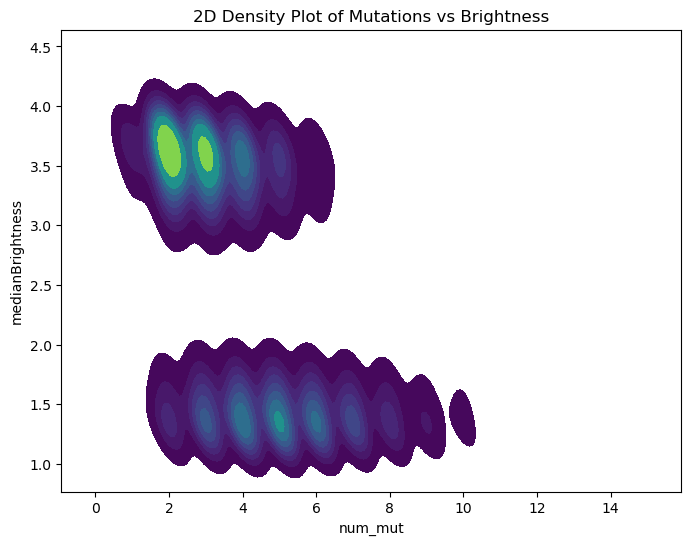

In [155]:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=dataset,
    x='num_mut',
    y='medianBrightness',
    fill=True,
    cmap="viridis",
    thresh=0.05
)
plt.title('2D Density Plot of Mutations vs Brightness')
plt.savefig('/Users/thomasbush/Downloads/2d_density_plot.png')
plt.show()


### Check the region of the mutation

In [123]:
# extract region of mut
pattern = r'\D*(\d+)\D*'
def extract_region_mut(mut:str)->int:
    if type(mut)==str:
        mutations = mut.split(":")
        regions = [re.search(pattern=pattern, string=m).group(1) for m in mutations]
        return regions

dataset['mut_region'] = dataset['aaMutations'].apply(lambda mut: extract_region_mut(mut))

In [132]:
filtered = dataset[dataset['num_mut'] < 2].copy()

# Encode regions numerically (e.g., 'brain' -> 0, 'liver' -> 1, etc.)
filtered['mut_region'] = filtered['mut_region'][1:].apply(lambda m: m[0])
filtered['mut_region_encoded'] = filtered['mut_region'].astype('category').cat.codes

# Compute correlation
corr = filtered['mut_region_encoded'].corr(filtered['medianBrightness'], method='spearman')
print(f"Spearman correlation between region and brightness (mut < 2): {corr:.3f}")

Spearman correlation between region and brightness (mut < 2): -0.104


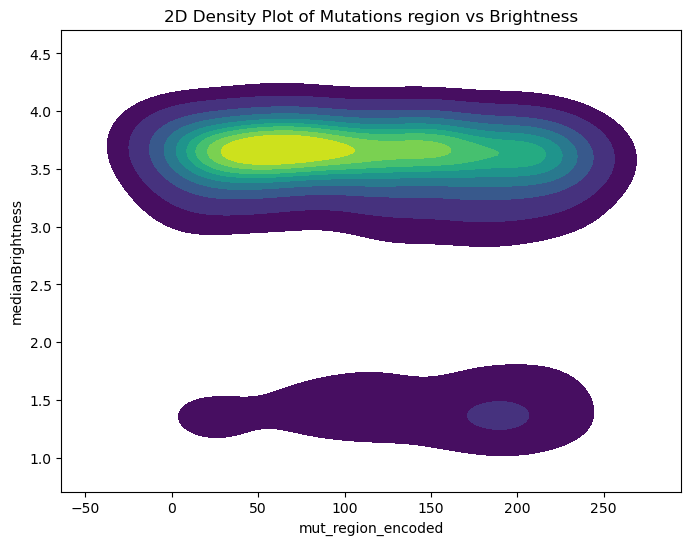

In [134]:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=filtered,
    x='mut_region_encoded',
    y='medianBrightness',
    fill=True,
    cmap="viridis",
    thresh=0.05
)
plt.title('2D Density Plot of Mutations region vs Brightness')
plt.show()


### create test data YAML


In [241]:
pip install pyyaml

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--seq', type=str, required=True)
parser.add_argument('--mut', type=str, required=True)
args = parser.parse_args()

print(args.seq)
print(args.mut)

In [252]:
import yaml

data_seq = {
    'version':'1',
    'sequences': {
        'id': 'A',
        'sequence': f'{seq}',
        'msa': 'empty'
    }
}

# Define the filename for the YAML output
filename = 'test_input.yaml'

# Open the file in write mode and dump the data
try:
    with open(filename, 'w') as file:
        yaml.dump(data_seq, file, sort_keys=False) # sort_keys=False preserves key order
    print(f"Data successfully written to '{filename}'")
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully written to 'test_input.yaml'


### Type of mutation

In [156]:
import torch
from torch import nn
import math

In [216]:
x = torch.randn((12, 5, 10))
#we then create a class:
class SelfAttentionModule(nn.Module):
    def __init__(self, x_in, c):
        super().__init__()
        self.c = c
        # we define the three linear layers
        self.linear_q = nn.Linear(x_in, c)
        self.linear_k = nn.Linear(x_in, c)
        self.linear_v = nn.Linear(x_in, c)
        self.linear_o = nn.Linear(c, x_in)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        # we apply the linear transformations
        Q = self.linear_q(x)
        # scale Q
        Q = Q / math.sqrt(self.c)
        K = self.linear_k(x)
        V = self.linear_v(x)
        # calculate affinities:
        affinities = torch.einsum('...kj, ...zi->...kz',Q, K)
        # convert to weights
        attn_weights = torch.softmax(affinities, dim=-1)
        # get the attn_values:
        attn_values = torch.einsum('...kz, ...zc->...kc', attn_weights, V)
        attn_values = self.linear_o(attn_values)
        return attn_values, attn_weights

In [163]:
attention = SelfAttentionModule(10, 8)
attn_val = attention(x)

In [165]:
!pip install seaborn

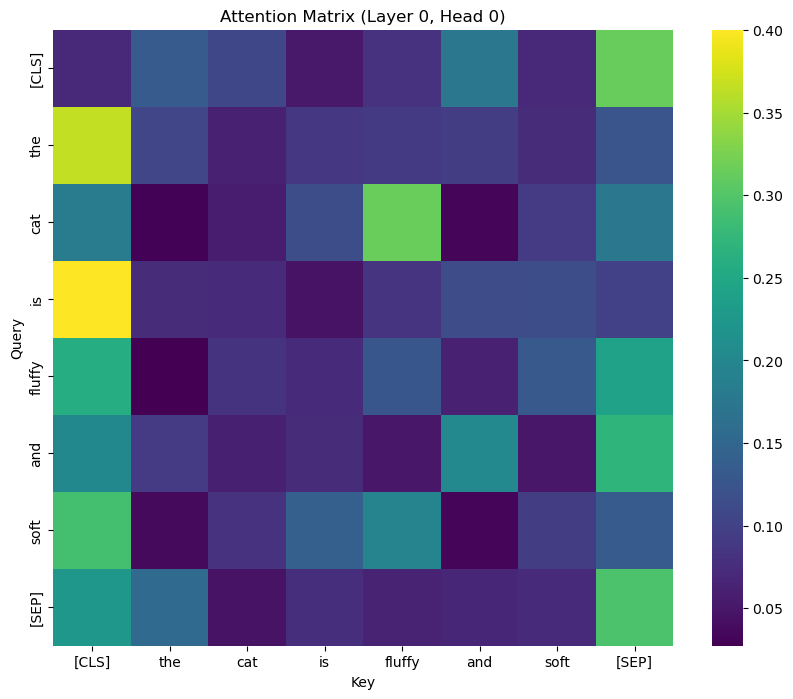

In [221]:
# let's try the viz
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load pretrained lightweight model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Your sentence
sentence = "The cat is fluffy and soft"

# Tokenize input
inputs = tokenizer(sentence, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Extract attention matrices (layer 0, head 0)
attentions = outputs.attentions  # List of layers -> [batch, heads, tokens, tokens]
attention_matrix = attentions[0][0, 0]  # First layer, first head

# Plot
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Matrix (Layer 0, Head 0)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()


In [211]:
attentions[0].shape

torch.Size([1, 12, 12, 12])

In [179]:
from torch import Tensor, nn
from typing import Dict, Iterable, Callable

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, input_ids: Tensor, attention_mask: Tensor) -> Dict[str, Tensor]:
        _ = self.model(input_ids, attention_mask)
        return self._features

In [199]:
feature_extractor = FeatureExtractor(AutoModel.from_pretrained(model_name, output_attentions=True), layers=['embeddings'])

In [200]:
with torch.no_grad():
    embeddings = feature_extractor(**inputs)

In [217]:
x = embeddings['embeddings']
attention = SelfAttentionModule(768, 64)
attn_val, attn_w = attention(x)

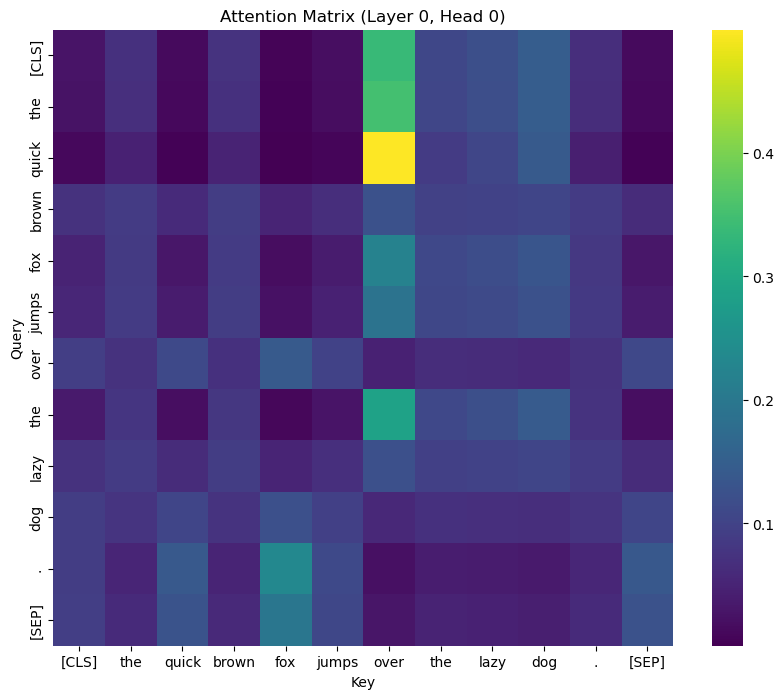

In [220]:
attention_matrix = attn_w[0].detach().numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Matrix (Layer 0, Head 0)")
plt.xlabel("Key")
plt.ylabel("Query")
plt.show()


In [230]:
torch.tril(torch.ones((4, 4)))

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [229]:
mask = torch.tril(torch.ones((4, 4))).bool()
x = torch.randn((4, 4))

# apply the mask 
x.masked_fill(mask==0, float('-inf'))

tensor([[ 1.6459,    -inf,    -inf,    -inf],
        [-2.6133, -1.6965,    -inf,    -inf],
        [ 0.2469,  0.0769,  0.3380,    -inf],
        [ 0.4569, -0.8654,  0.7813, -0.9268]])